In [412]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import math

In [413]:
# import csv file into table
order_df = pd.read_csv('order.csv')
user_df = pd.read_csv('user.csv')
listening_df = pd.read_csv('listening.csv')

In [414]:
order_df.head()

,order_id,order_date,user_id,order_type,order_amount,age,gender,register_date,platform
0,6706,08/16/2020,44822,VIP,199000,44,female,08/16/2020,ios
1,6998,08/23/2020,47128,VIP,199000,32,male,08/21/2020,ios
2,6927,08/21/2020,47134,VIP,199000,43,male,08/21/2020,ios
3,7054,08/25/2020,45972,VIP,199000,22,male,08/19/2020,website
4,6929,08/21/2020,43556,VIP,199000,22,male,08/07/2020,ios


In [415]:
user_df.head()

,user_id,user_type,gender,age,region,platform,register_date,total_listening_cnt,total_listening_amt
0,86229,free,male,unkown,local,android,11/27/2020,218,4151.3
1,48053,free,male,26,local,ios,08/24/2020,19,278.6
2,46340,free,male,33,local,website,08/19/2020,28,170.5
3,66659,free,male,29,local,website,10/22/2020,345,6721.4
4,59396,free,male,unkown,local,android,09/29/2020,23,52.5


In [416]:
listening_df.head()

,playlist_id,playlist_name,level1_category,level2_category,vip,playlist_duration,playlist_listening_amt,user_id,listening_timestamp,listening_date
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,12/03/2020
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,10/30/2020
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,12/15/2020
3,4581,[Sách Tóm Tắt] Đọc Vị Bất Kỳ Ai,Sách tóm tắt,Sách tóm tắt,free,24.8,2.1,85469,23:09,11/29/2020
4,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,19.0,70171,21:09,12/06/2020


1. Order table features:
   * **order_id**: Unique order indentifier in-app.
   * **order_date**: Date when to user paid for an audio.
   * **user_id**: Unique user indentifier.
   * **order_type**: Type of order, include VIP/Coin/9K.
   * **order_amount**: The money value of an order.
   * **age**: Age of user.
   * **gender**: Gender of user.
   * **register_date**: User registration date.
   * **platform**: User device platform (only ios/android).
2. User table features:
   * **user_id**: Unique user indentifier.
   * **user_type**: Type of user, include VIP/Free.
   * **gender**: Gender of user.
   * **age**: Age of user.
   * **region**: Region that user come from (only local/cb).
   * **platform**: User device platform (only ios/android).
   * **register_date**: User registration date.
   * **total_listening_cnt**: Total listening count of a user.
   * **total_listening_amt**: Total listening of time in minutes.
3. Listening table features:
   * **playlist_id**: Unique audio indentifier.
   * **playlist_name**: Audio name.
   * **level1_category**: The category of audio (Level1).
   * **level2_category**: The category of audio (Level2).
   * **vip**: Type of audio, include VIP/free.
   * **playlist_duration**: Total duration of audio (in minutes).
   * **playlist_listening_amt**: Total time listening of a user on the audio.
   * **listening_timestamp**: The time user start listeing the audio (24h format).
   * **listening_date**: The time user start listeing the audio.

### **Summary:**
**RFM Clustering**
 - R: Recency - Day since last listening_date (if user hasn't listened yet, change to day since last order_date)
 - F: Frequency - (Total_listening_cnt/Time_window) (Time_window is calculated as last_listening_date - first_listening_date, if user hasn't listened yet it will be NaN)
 - M: Monetary - (Total_order_amt/Time_window) (Time_window is calculated as last_listening_date - first_listening_date, if time_window is NaN monetary will equal to itself.

## 1. Calculate Recency Score (R): How many days past from last listening date?

In [417]:
# find the last listening_date, then calculate the recency first
df_recency = listening_df #make a coppy of order to make recency
df_recency['listening_date'] = pd.to_datetime(df_recency['listening_date'])
reference_date = pd.to_datetime('2020-12-31')
df_recency = df_recency.groupby(by='user_id', as_index=False)['listening_date'].max()

df_recency.columns = ['user_id', 'max_date']

df_recency['recency'] = df_recency['max_date'].apply(lambda row: (reference_date - row).days)
df_recency = df_recency[['user_id', 'recency']]
df_recency.head(10)

,user_id,recency
0,40834,176
1,40835,85
2,40839,81
3,40840,28
4,40842,153
5,40843,2
6,40844,181
7,40847,182
8,40849,183
9,40853,183


In [418]:
# find the last order_date in case of user hasn't listened yet
order_recency = order_df.groupby(by='user_id', as_index=False)['order_date'].max()
order_recency['order_date'] = pd.to_datetime(order_recency['order_date'])
order_recency['recency_order'] = order_recency['order_date'].apply(lambda row: (reference_date - row).days)
order_recency.head()

,user_id,order_date,recency_order
0,40843,2020-10-21,71
1,40861,2020-09-09,113
2,41003,2020-10-27,65
3,41014,2020-10-15,77
4,41057,2020-10-20,72


## 2. Calculating Frequency score (F): How frequently users listen everday?

In [419]:
# find the total listening cnt of whole duration
listening_df['listening_date'] = pd.to_datetime(listening_df['listening_date'])

df_frequency = listening_df
df_frequency = df_frequency.groupby(by='user_id')['playlist_id'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['user_id', 'frequency']
df_frequency.head()

,user_id,frequency
0,40834,2
1,40835,5
2,40839,60
3,40840,491
4,40842,67


In [420]:
# find the time window (the reason of using time window is to check the consecutive frequency)
time_df = listening_df
time_df_max = time_df.groupby(by='user_id')['listening_date'].max()
time_df_min = time_df.groupby(by='user_id')['listening_date'].min()
df_frequency = pd.merge(df_frequency, time_df_max, how='left', on ='user_id')
df_frequency = pd.merge(df_frequency, time_df_min, how='left', on ='user_id')
df_frequency.columns = ['user_id', 'frequency', 'latest_listening', 'first_listening']
df_frequency['latest_listening'] = pd.to_datetime(df_frequency['latest_listening'])
df_frequency['first_listening'] = pd.to_datetime(df_frequency['first_listening'])

df_frequency['time_range'] = (df_frequency['latest_listening'] - df_frequency['first_listening']).dt.days + 1
df_frequency.head(10)

,user_id,frequency,latest_listening,first_listening,time_range
0,40834,2,2020-07-08,2020-07-08,1
1,40835,5,2020-10-07,2020-09-02,36
2,40839,60,2020-10-11,2020-07-21,83
3,40840,491,2020-12-03,2020-07-23,134
4,40842,67,2020-07-31,2020-07-07,25
5,40843,48,2020-12-29,2020-07-01,182
6,40844,149,2020-07-03,2020-07-01,3
7,40847,4,2020-07-02,2020-07-02,1
8,40849,17,2020-07-01,2020-07-01,1
9,40853,23,2020-07-01,2020-07-01,1


## 3. Calculating Moneytary Score (M): How much user spent a day in terms of consecutive frequency?

In [421]:
# find the total monetary of the whole duration
order_df['order_date'] = pd.to_datetime(order_df['order_date'])

# make a copy of order_df
df_monetary = order_df
df_monetary = df_monetary.groupby(by='user_id')['order_amount'].sum()

df_monetary = df_monetary.reset_index()
df_monetary.columns = ['user_id', 'monetary']
df_monetary.head()

,user_id,monetary
0,40843,27000
1,40861,199000
2,41003,599000
3,41014,398000
4,41057,599000


# 4. Concat all RFM into one table

In [422]:
rfm_df = pd.merge(df_monetary, df_frequency[['user_id', 'frequency', 'time_range']], how='left', on='user_id')
rfm_df = pd.merge(rfm_df, df_recency, how='left', on='user_id')
rfm_df = pd.merge(rfm_df, order_recency[['user_id', 'recency_order']], how='left', on='user_id')
# rfm_df['monetary'] = rfm_df.apply(lambda x: x['monetary'] if math.isnan(x['time_range']) == True else x['monetary'] / x['time_range'], axis = 1)
rfm_df['frequency'] = rfm_df['frequency'] / rfm_df['time_range']
rfm_df['frequency'] = rfm_df['frequency'].fillna(value=float(0.0))
rfm_df['recency'] = rfm_df.apply(lambda x: x['recency_order'] if math.isnan(x['recency']) == True else x['recency'], axis = 1)
rfm_df = rfm_df[['user_id', 'recency', 'frequency', 'monetary']]
rfm_df.head()

,user_id,recency,frequency,monetary
0,40843,2.0,0.263736,27000
1,40861,29.0,2.169935,199000
2,41003,11.0,2.208955,599000
3,41014,25.0,0.703226,398000
4,41057,5.0,3.446328,599000


In [423]:
# rfm_df.to_csv('rfm_draft.csv', encoding='utf-8', index=False)

In [424]:
def visualize_numerical(df, column, target = None):

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4));

    sns.histplot(df[column], ax=ax1, kde=True);
    ax1.set_xlabel(column);
    ax1.set_ylabel('Number');
    ax1.set_title(f'{column}  Distribution');
    
    if(target == None):
        sns.boxplot(y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_ylabel(column);
    else:
        sns.boxplot(x=target, y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_xlabel('Target');
        ax2.set_ylabel(column);
    
    plt.show()

def visualize_numerical_lst(df, numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',\
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], target = None):
    for column in numerical:
        visualize_numerical(df,column, target)
        print();

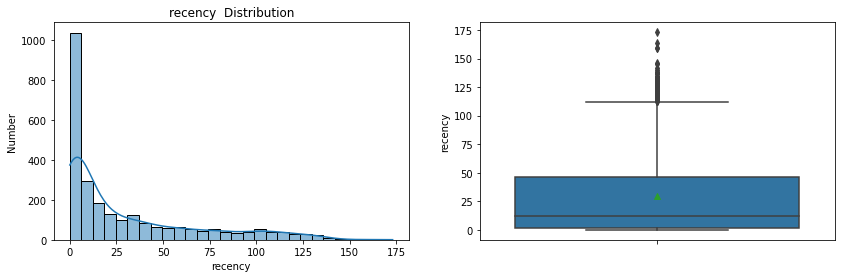

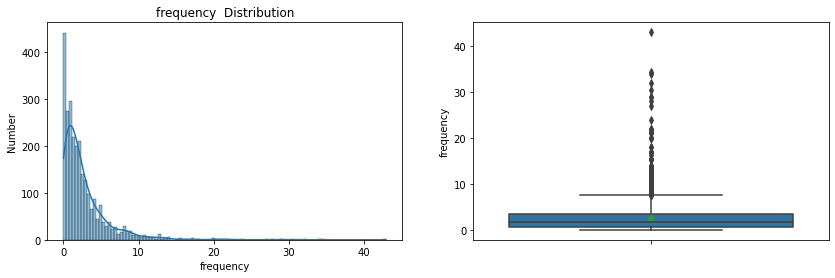

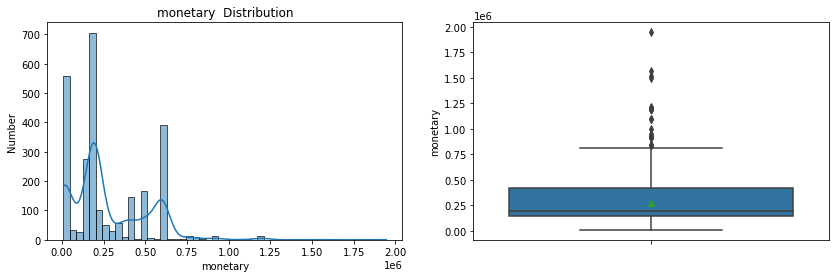

In [425]:
visualize_numerical_lst(rfm_df,["recency","frequency","monetary"])

In [426]:
## Thay thế Density của các trường hợp >quantile95 bằng chính nó
q95 = rfm_df["monetary"].quantile(0.995)
rfm_df["monetary"]=rfm_df["monetary"].map(lambda x: q95 if x>q95 else x)

q95 = rfm_df["frequency"].quantile(0.995)
rfm_df["frequency"]=rfm_df["frequency"].map(lambda x: q95 if x>q95 else x)

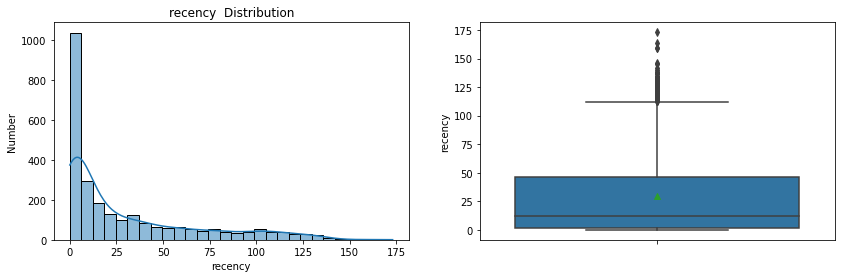

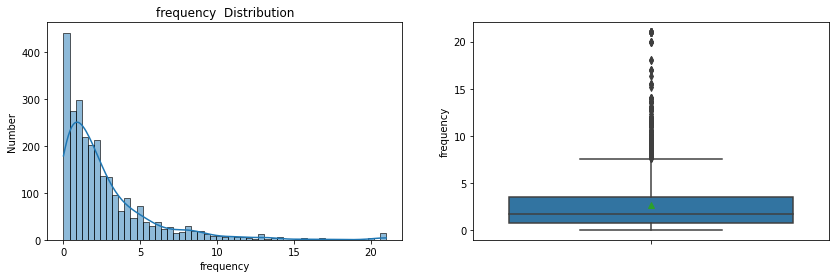

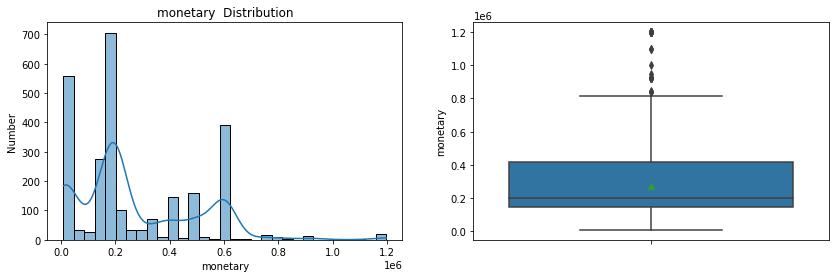

In [427]:
visualize_numerical_lst(rfm_df,["recency","frequency","monetary"])

In [428]:
rfm_df['recency'].describe()

count    2638.000000
mean       29.583017
std        36.605965
min         0.000000
25%         2.000000
50%        12.000000
75%        46.000000
max       173.000000
Name: recency, dtype: float64

In [429]:
def plot_sse(sse):
#     sse = find_sse(df.loc[:,[col]], max_k = 10) 
    plt.figure()
    plt.plot(list(sse.keys()),list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.show() 

# for Ebowl
def find_sse(df, max_k):
    sse = {}
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        kmeans.fit(df)
        df['clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    return sse

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

def run_kmean_clustering(df,cluster_cols,k_cluster,k_iter = 1000):
    kmeans = KMeans(n_clusters=k_cluster, max_iter = k_iter )
    kmeans.fit(df[cluster_cols])
    prefix = cluster_cols[0]
    df[str(prefix)+"Cluster"]= kmeans.predict((df[cluster_cols]))
    return df


<Figure size 576x288 with 0 Axes>

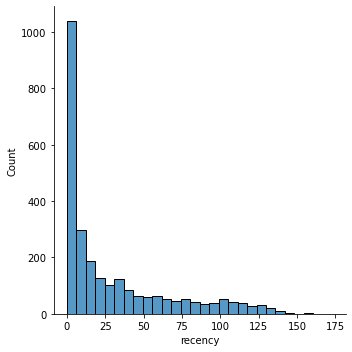

In [430]:
plt.figure(figsize=(8,4))
sns.displot(rfm_df.recency, kde=False)

<Figure size 576x288 with 0 Axes>

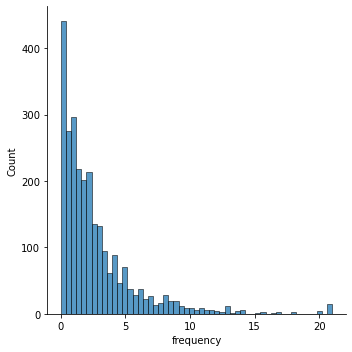

In [431]:
plt.figure(figsize=(8,4))
sns.displot(rfm_df.frequency, kde=False)

<Figure size 576x288 with 0 Axes>

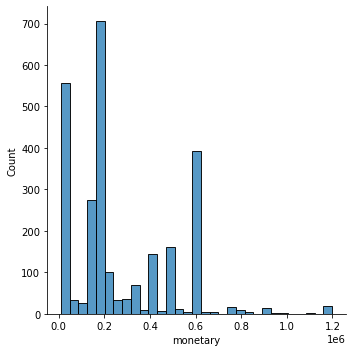

In [432]:
plt.figure(figsize=(8,4))
sns.displot(rfm_df.monetary, kde=False)

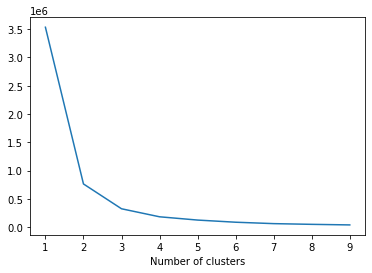

In [433]:
## Elbow Method to determine K
sse = find_sse(rfm_df.loc[:,['recency']], max_k = 10) 
plot_sse(sse)

In [434]:
# ## RecencyCluster_k = 3
k_clus = 3
rfm_df = run_kmean_clustering(rfm_df,["recency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
rfm_df = order_cluster('recencyCluster', 'recency',rfm_df,False)
rfm_df.groupby("recencyCluster")['recency'].describe()

# ## see details of each cluster - Recency

,count,mean,std,min,25%,50%,75%,max
recencyCluster,,,,,,,,
0,387.0,104.121447,18.522867,76.0,89.5,104.0,117.0,173.0
1,563.0,47.035524,13.738877,27.0,35.0,45.0,58.0,75.0
2,1688.0,6.672986,7.198905,0.0,1.0,4.0,11.0,26.0


**Recency** chia làm 3 nhóm:
1. Nhóm 0: Hibernate (2-3 tháng)
2. Nhóm 1: Sleep (1-2 tháng)
3. Nhóm 2: Active (< 1 tháng)

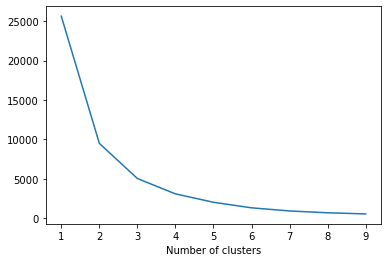

In [435]:
sse = find_sse(rfm_df.loc[:,['frequency']], max_k = 10) 
plot_sse(sse) 

In [436]:
# ## FrequencyCluster_k = 4
k_clus = 4

rfm_df = run_kmean_clustering(rfm_df,["frequency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
rfm_df = order_cluster('frequencyCluster', 'frequency',rfm_df,True)
rfm_df['frequency']=round(rfm_df['frequency'],0)
rfm_df.groupby("frequencyCluster")['frequency'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
frequencyCluster,,,,,,,,
0,1649.0,0.973924,0.771881,0.0,0.00,1.0,2.0,2.0
1,726.0,3.833333,1.085855,2.0,3.00,4.0,5.0,6.0
2,225.0,8.706667,1.885850,6.0,7.00,8.0,10.0,13.0
3,38.0,18.078947,2.953528,14.0,15.25,19.0,21.0,21.0


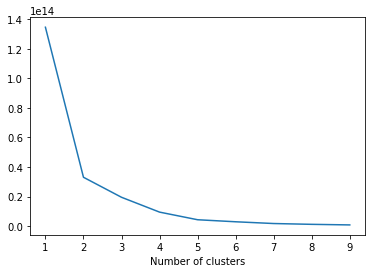

In [437]:
sse = find_sse(rfm_df.loc[:,['monetary']], max_k = 10) 
plot_sse(sse) 

In [438]:
k_clus = 3
rfm_df = run_kmean_clustering(rfm_df,["monetary"],k_cluster=k_clus)

## Sắp theo thứ tự M càng cao thì Cluster càng cao
rfm_df = order_cluster('monetaryCluster', 'monetary',rfm_df,True)
rfm_df.groupby("monetaryCluster")['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
monetaryCluster,,,,,,,,
0,614.0,20498.371336,21361.928079,9000.0,9000.0,9000.0,18000.0,108000.0
1,1228.0,202728.827362,45613.062902,113000.0,194000.0,199000.0,199000.0,379000.0
2,796.0,569195.979899,144764.217004,388000.0,499000.0,599000.0,599000.0,1198000.0


In [439]:
def frequency_score(x):
    if x['frequency'] >= 14:
        frequency = 4
    elif x['frequency'] < 14 and x['frequency'] >= 6:
        frequency = 3
    elif x['frequency'] < 6 and x['frequency'] >= 2:
        frequency = 2
    else:
        frequency = 1
    return frequency

In [440]:
def recency_score(x):
    if x['recency'] <= 27:
        recency = 3
    elif x['recency'] > 27 and x['recency'] < 76:
        recency = 2
    else:
        recency = 1
    return recency

In [441]:
def monetary_score(x):
    if x['monetary'] >= 380000:
        monetary = 3
    elif x['monetary'] < 380000 and x['monetary'] >= 110000:
        monetary = 2
    else:
        monetary = 1
    return monetary

In [442]:
rfm_df['R'] = rfm_df.apply(recency_score, axis=1)
rfm_df['F'] = rfm_df.apply(frequency_score, axis=1)
rfm_df['M'] = rfm_df.apply(monetary_score, axis=1)
rfm_df.head()

,user_id,recency,frequency,monetary,recencyCluster,frequencyCluster,monetaryCluster,R,F,M
0,40843,2.0,0.0,27000.0,2,0,0,3,1,1
1,41955,0.0,1.0,45000.0,2,0,0,3,1,1
2,44112,0.0,0.0,9000.0,2,0,0,3,1,1
3,45239,1.0,2.0,9000.0,2,0,0,3,2,1
4,45647,0.0,0.0,45000.0,2,0,0,3,1,1


In [443]:
rfm_df.to_csv('rfm_output.csv', encoding='utf-8', index=False)